In [8]:
path = r'E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA'

In [9]:
import os 
os.listdir(path)

['driving_log.csv', 'IMG']

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Flatten , Dense ,Dropout, MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import ntpath
import random
from imgaug import augmenters as iaa
%matplotlib inline

In [11]:
columns=['center', 'left', 'right' , 'steering' , 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(path,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

center  \
0  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\center_2019_02_04_12_54_22_028.jpg   
1  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\center_2019_02_04_12_54_22_101.jpg   
2  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\center_2019_02_04_12_54_22_173.jpg   
3  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\center_2019_02_04_12_54_22_245.jpg   
4  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\center_2019_02_04_12_54_22_318.jpg   

                                                                                                 left  \
0  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\left_2019_02_04_12_54_22_028.jpg   
1  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\left_2019_02_04_12_54_22_101.jpg   
2  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\left_2019_02_04_12_54_22_173.jpg   
3  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\left_2019_02_04_12_54_22_245.jpg   
4  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\left_2019_02_04_12_54_22_318.jpg   

                                                                                                 right  \
0  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\right_2019_02_04_12_54_22_028.jpg   
1  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\right_2019_02_04_12_54_22_101.jpg   
2  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\right_2019_02_04_12_54_22_173.jpg   
3  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\right_2019_02_04_12_54_22_245.jpg   
4  E:\Courses\self driving car udemy\14-Behavioural Cloning\DATA\IMG\right_2019_02_04_12_54_22_318.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000008  
1  0.0       0.0       0.0      0.000010  
2  0.0       0.0       0.0      0.000011  
3  0.0       0.0       0.0      0.000003  
4  0.0       0.0       0.0      0.000009

In [12]:
def path_leaf(path):
    head , tail = ntpath.split(path)
    return tail

In [13]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [14]:
data.head()

center                              left  \
0  center_2019_02_04_12_54_22_028.jpg  left_2019_02_04_12_54_22_028.jpg   
1  center_2019_02_04_12_54_22_101.jpg  left_2019_02_04_12_54_22_101.jpg   
2  center_2019_02_04_12_54_22_173.jpg  left_2019_02_04_12_54_22_173.jpg   
3  center_2019_02_04_12_54_22_245.jpg  left_2019_02_04_12_54_22_245.jpg   
4  center_2019_02_04_12_54_22_318.jpg  left_2019_02_04_12_54_22_318.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_02_04_12_54_22_028.jpg  0.0       0.0       0.0      0.000008  
1  right_2019_02_04_12_54_22_101.jpg  0.0       0.0       0.0      0.000010  
2  right_2019_02_04_12_54_22_173.jpg  0.0       0.0       0.0      0.000011  
3  right_2019_02_04_12_54_22_245.jpg  0.0       0.0       0.0      0.000003  
4  right_2019_02_04_12_54_22_318.jpg  0.0       0.0       0.0      0.000009

<BarContainer object of 25 artists>

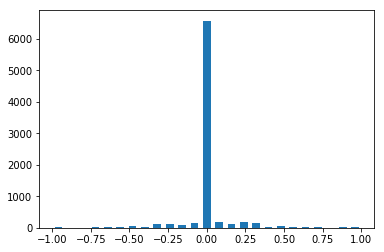

In [15]:
num_bins = 25
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width = 0.05)

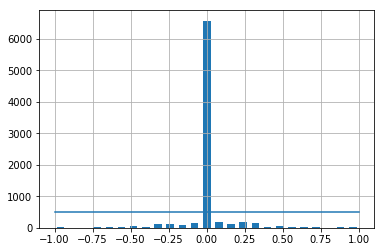

In [16]:
samples_per_bin = 500
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin,samples_per_bin))
plt.grid()

total data:  8117
removed:  6082
remaining data:  2035


<BarContainer object of 25 artists>

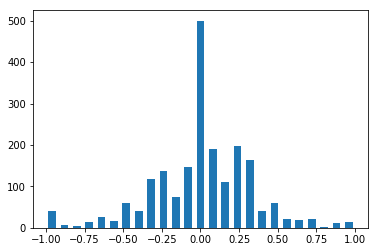

In [17]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed: ',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining data: ', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width = 0.05)

In [18]:
print(data.iloc[1])
def load_img_steering(datadir,data):
    img_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
        img_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    img_paths = np.asarray(img_path)
    steerings = np.asarray(steering)
    return img_paths , steerings

center      center_2019_02_04_12_54_22_756.jpg
left        left_2019_02_04_12_54_22_756.jpg  
right       right_2019_02_04_12_54_22_756.jpg 
steering   -0.35                              
throttle    1                                 
reverse     0                                 
speed       2.89855                           
Name: 10, dtype: object


In [19]:
image_paths, steerings = load_img_steering(path+r'\IMG',data)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2,random_state=0)
print('Training samples: {}\n valid samples: {}'.format(len(X_train),len(X_valid)))

Training samples: 1628
 valid samples: 407


Text(0.5, 1.0, 'validaition set')

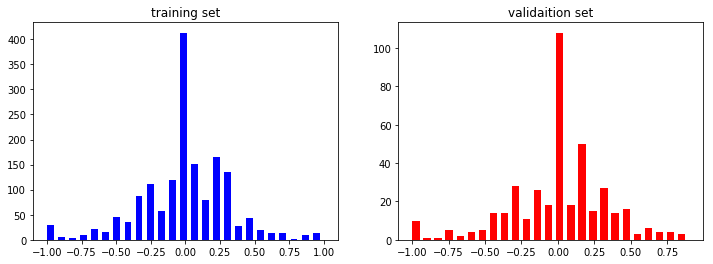

In [21]:
fig, axes = plt.subplots(1,2,figsize = (12,4))
axes[0].hist(y_train,bins = num_bins, width = 0.05,color = 'b')
axes[0].set_title('training set')
axes[1].hist(y_valid,bins = num_bins, width = 0.05,color = 'r')
axes[1].set_title('validaition set')

In [22]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

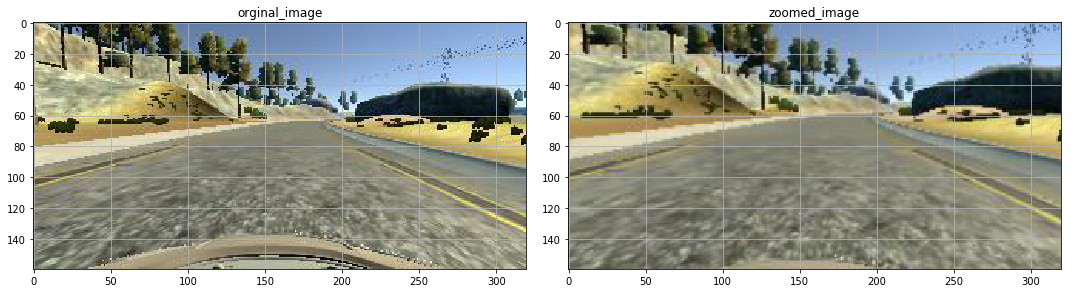

In [23]:
image  = image_paths[random.randint(0,1000)]
orignal_image = mpimg.imread(image)
zoomed_image = zoom(orignal_image)

fig, axes = plt.subplots(1,2,figsize = (15,20))
fig.tight_layout()
axes[0].imshow(orignal_image)
axes[0].set_title("orginal_image")
axes[0].grid()
axes[1].imshow(zoomed_image)
axes[1].set_title('zoomed_image')
axes[1].grid()

In [24]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

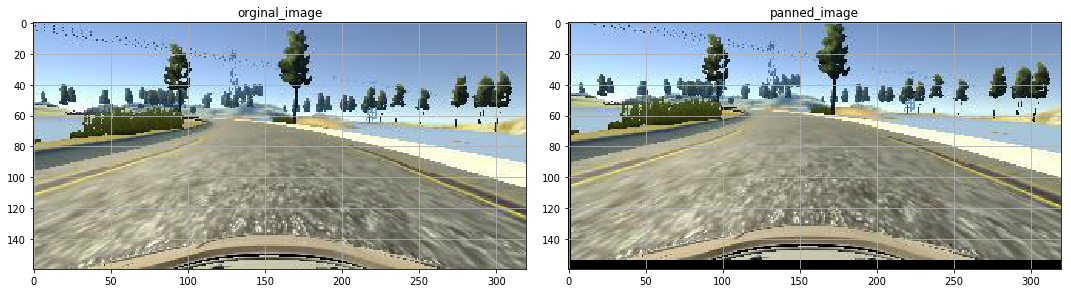

In [25]:
image  = image_paths[random.randint(0,1000)]
orignal_image = mpimg.imread(image)
panned_image = pan(orignal_image)

fig, axes = plt.subplots(1,2,figsize = (15,20))
fig.tight_layout()
axes[0].imshow(orignal_image)
axes[0].set_title("orginal_image")
axes[0].grid()
axes[1].imshow(panned_image)
axes[1].set_title('panned_image')
axes[1].grid()

In [26]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

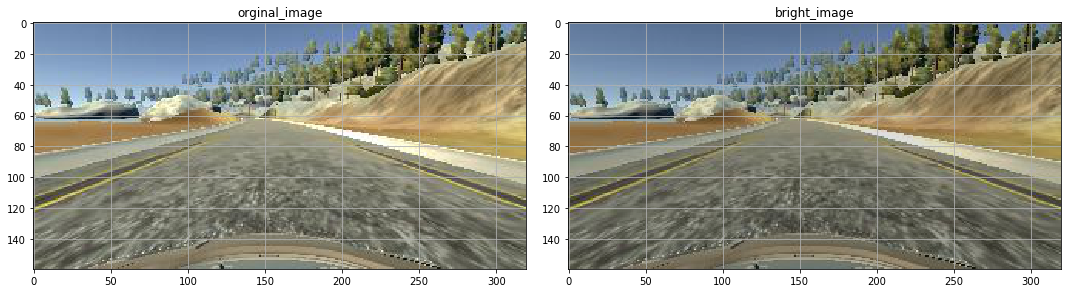

In [27]:
image  = image_paths[random.randint(0,1000)]
orignal_image = mpimg.imread(image)
brightness_image = img_random_brightness(orignal_image)

fig, axes = plt.subplots(1,2,figsize = (15,20))
fig.tight_layout()
axes[0].imshow(orignal_image)
axes[0].set_title("orginal_image")
axes[0].grid()
axes[1].imshow(brightness_image)
axes[1].set_title('bright_image')
axes[1].grid()

In [28]:
def img_random_flip(image,steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

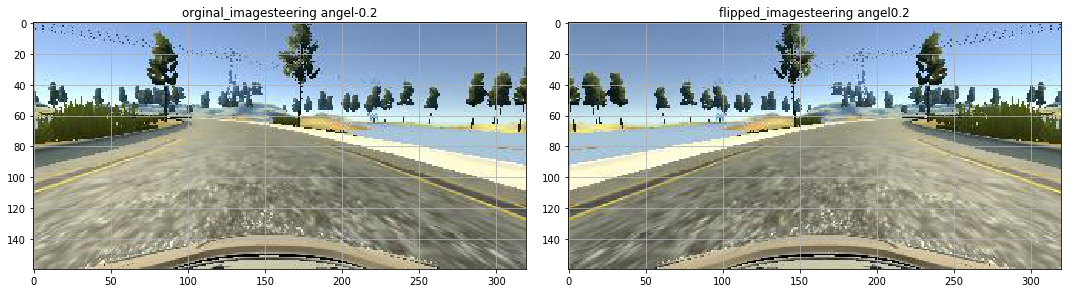

In [38]:
random_index = random.randint(0,1000)
image  = image_paths[random_index]
steering_angel = steerings[random_index]
orignal_image = mpimg.imread(image)
flipped_image , flip_steering_image = img_random_flip(orignal_image,steering_angel)

fig, axes = plt.subplots(1,2,figsize = (15,20))
fig.tight_layout()
axes[0].imshow(orignal_image)
axes[0].set_title("orginal_image"+ "steering angel"+ str(steering_angel))
axes[0].grid()
axes[1].imshow(flipped_image)
axes[1].set_title('flipped_image'+"steering angel"+ str(flip_steering_image))
axes[1].grid()

In [30]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [31]:
ncol = 2
nrow = 10

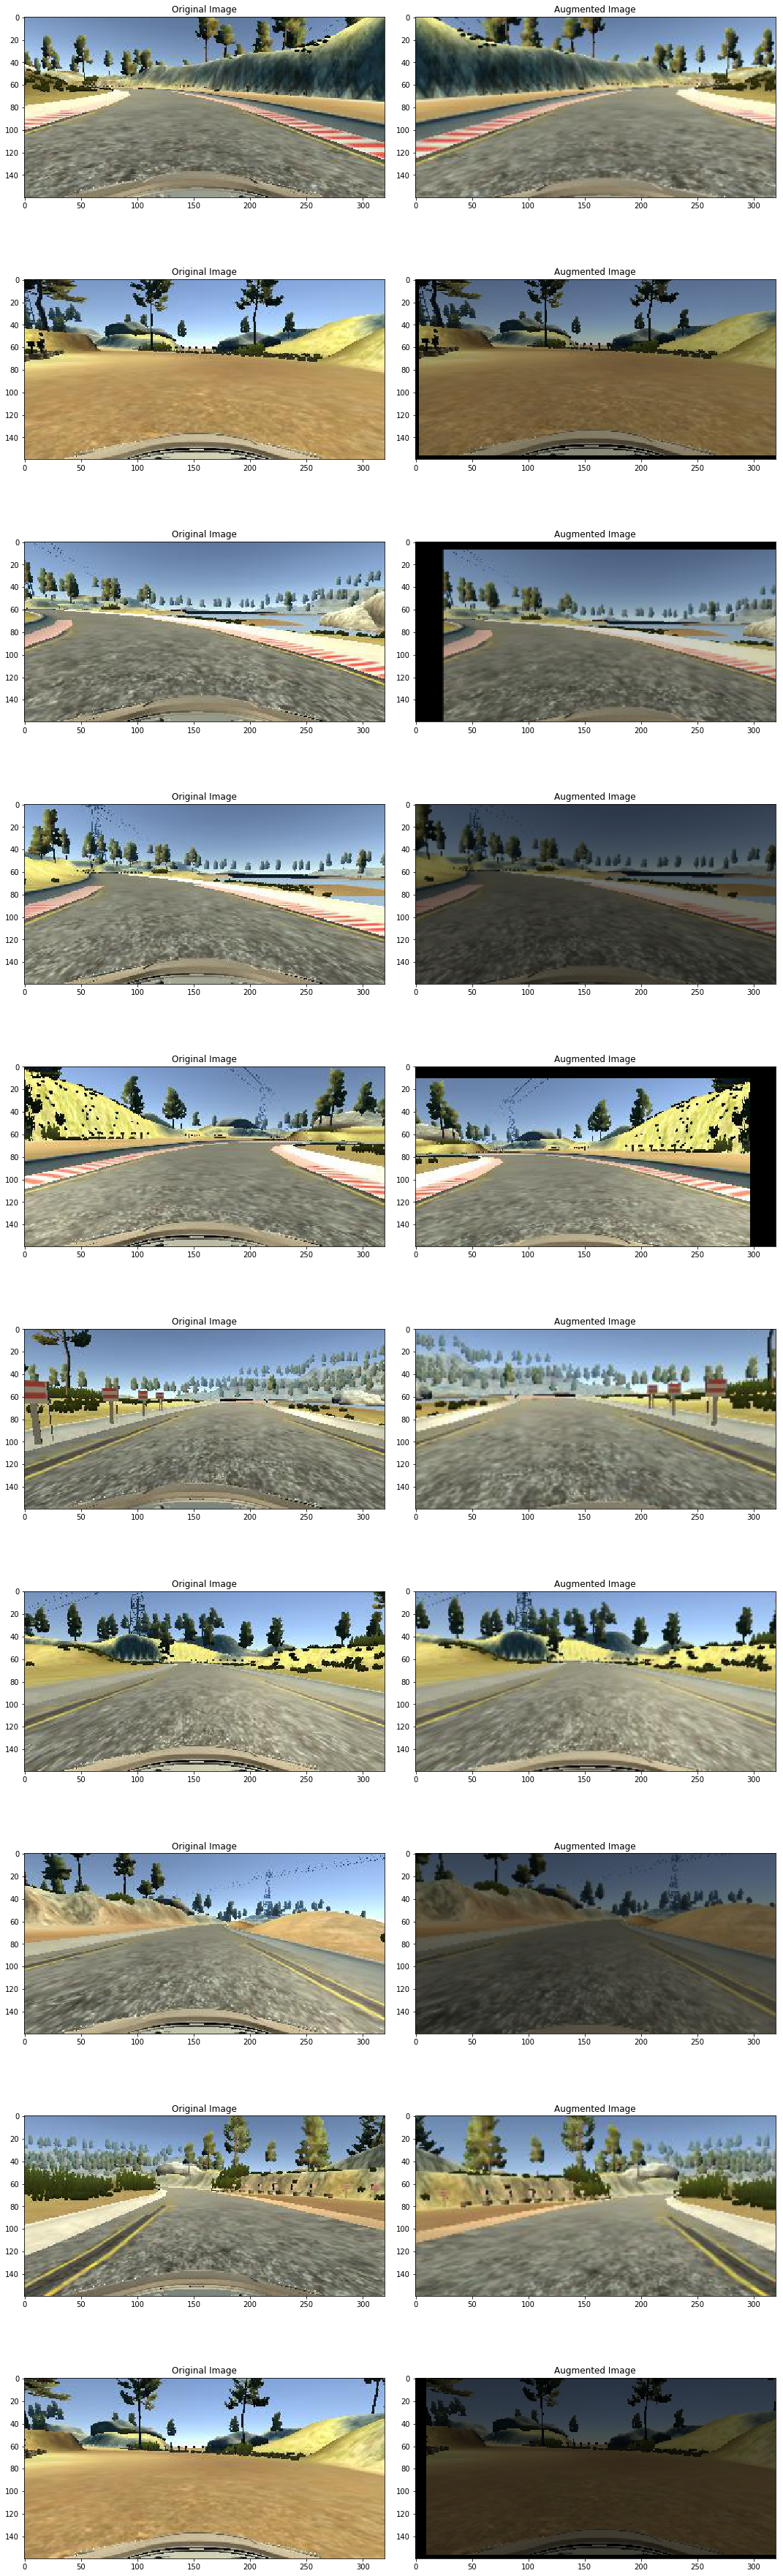

In [32]:
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [33]:
def img_preprocessing(img):
    #img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3), 0)
    img = cv2.resize(img,(200,66))
    img = img/255
    return img

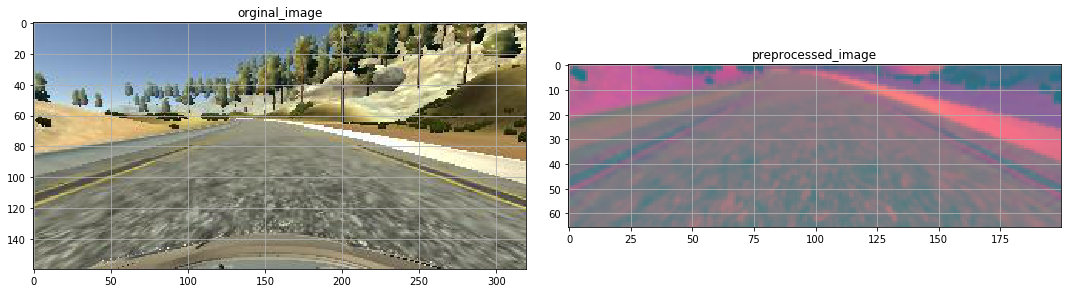

In [34]:
image = image_paths[100]

orginal_image = mpimg.imread(image)
preprocessed_image = img_preprocessing(orginal_image)
fig , axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(orginal_image)
axes[0].set_title("orginal_image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("preprocessed_image")
axes[0].grid()
axes[1].grid()

In [35]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0,len(image_paths)-1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            im = img_preprocessing(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

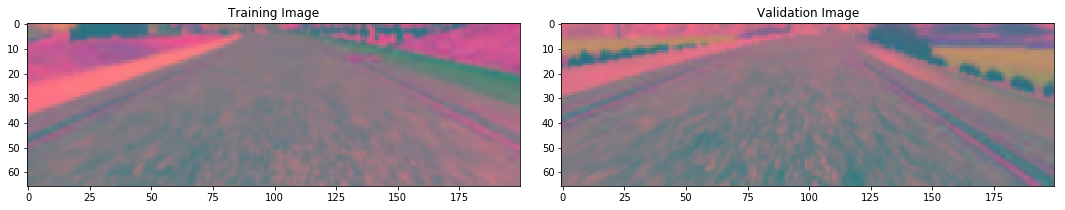

In [36]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [30]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24,(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48,( 5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64,( 3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100,activation='elu'))
    model.add(Dense(50,activation='elu'))
    model.add(Dense(10,activation='elu'))
    model.add(Dense(1))
    optimizer = Adam(lr=1e-4)
    model.compile(loss= 'mse',optimizer=optimizer)
    return model

In [31]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [32]:
model.fit_generator(batch_generator(X_train,y_train,100,1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1
                   )

Epoch 1/10
300/300 [==============================] - 1973s 7s/step - loss: 0.1134 - val_loss: 0.0851
Epoch 2/10
300/300 [==============================] - 1864s 6s/step - loss: 0.0936 - val_loss: 0.0726
Epoch 3/10
300/300 [==============================] - 1871s 6s/step - loss: 0.0908 - val_loss: 0.0707
Epoch 4/10
300/300 [==============================] - 1858s 6s/step - loss: 0.0860 - val_loss: 0.0631
Epoch 5/10
300/300 [==============================] - 1863s 6s/step - loss: 0.0823 - val_loss: 0.0679
Epoch 6/10
300/300 [==============================] - 1862s 6s/step - loss: 0.0775 - val_loss: 0.0595
Epoch 7/10
300/300 [==============================] - 1861s 6s/step - loss: 0.0722 - val_loss: 0.0528
Epoch 8/10
300/300 [==============================] - 1865s 6s/step - loss: 0.0658 - val_loss: 0.0533
Epoch 9/10
300/300 [==============================] - 1867s 6s/step - loss: 0.0645 - val_loss: 0.0479
Epoch 10/10
300/300 [==============================] - 1866s 6s/step - loss: 0.062

Text(0.5, 0, 'epoch')

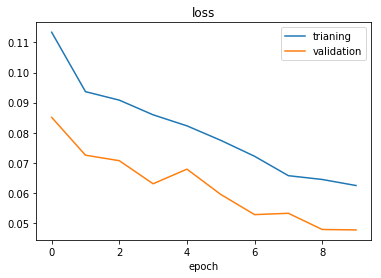

In [33]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['trianing','validation'])
plt.title('loss')
plt.xlabel('epoch')

In [35]:
model.save('model_sim.h5')

In [31]:
from keras.models import load_model

In [32]:
model = load_model('model_sim_1.h5')

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [34]:
model.fit_generator(batch_generator(X_train,y_train,100,1),
                    steps_per_epoch=300,
                    epochs=4,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1
                   )

Epoch 1/4
300/300 [==============================] - 1735s 6s/step - loss: 0.1846 - val_loss: 0.1237
Epoch 2/4
300/300 [==============================] - 1738s 6s/step - loss: 0.1548 - val_loss: 0.1204
Epoch 3/4
300/300 [==============================] - 1839s 6s/step - loss: 0.1461 - val_loss: 0.1126
Epoch 4/4
300/300 [==============================] - 1758s 6s/step - loss: 0.1378 - val_loss: 0.1086


In [35]:
model.save('model_sim_2.h5')

Text(0.5, 0, 'epoch')

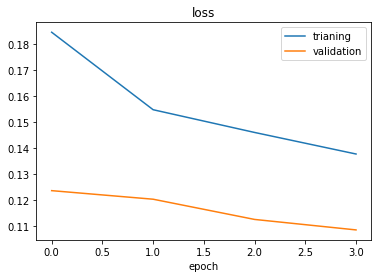

In [36]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['trianing','validation'])
plt.title('loss')
plt.xlabel('epoch')